In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import glob 
import random
from tqdm import tqdm

#### Manage image folder

In [2]:
root = "/Users/Fashiar/Dropbox/Data/COVID-19-Project/Montgomery-CXR/MontgomerySet"
cxrFolder = os.path.join(root, "CXR_png")
maskFolder = os.path.join(root, "ManualMask")
maskFolderL = os.path.join(maskFolder, "leftMask")
maskFolderR = os.path.join(maskFolder, "rightMask")

#### Load a sample image

(4020, 4892, 3)


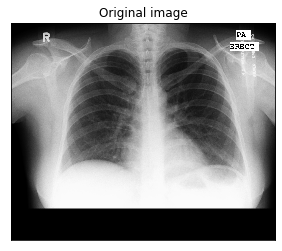

In [3]:
imgName = "MCUCXR_0001_0.png"
imgFile = os.path.join(cxrFolder, imgName)

img = cv.imread(imgFile)
print(img.shape)

plt.imshow(img, "gray")
plt.title("Original image")
plt.xticks([])
plt.yticks([])
plt.show()

#### Load the lung mask

(4020, 4892, 3)
(4020, 4892, 3)


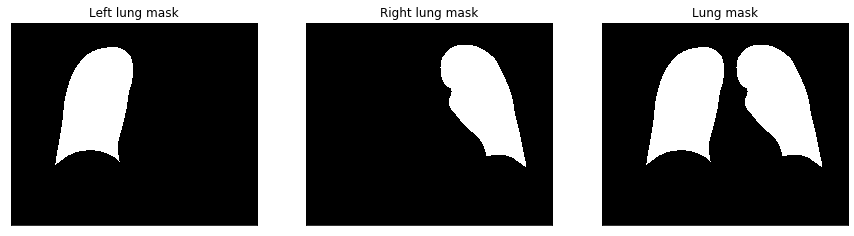

In [4]:
leftLungFile = os.path.join(maskFolderL, imgName)
rightLungFile = os.path.join(maskFolderR, imgName)
leftLung = cv.imread(leftLungFile)
rightLung = cv.imread(rightLungFile)
print(leftLung.shape)

lungMask = cv.add(leftLung, rightLung)
print(lungMask.shape)

titles = ['Left lung mask', 'Right lung mask', 'Lung mask' ]
images = [leftLung, rightLung, lungMask]

plt.figure(figsize=(15,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

#### Scaling (4892 X 4892) and resizing (1024 X 1024) image

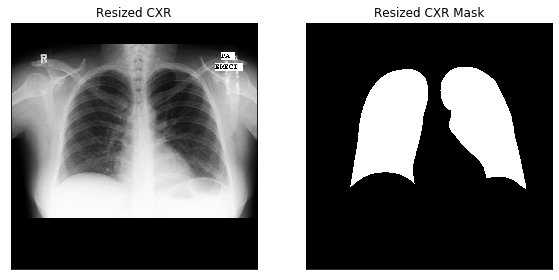

In [5]:
h, w, c = img.shape
# Compute center offset
xx = (4892 - w) // 2
yy = (4892 - h) // 2

scaledImg = np.zeros((4892, 4892, 3), dtype=np.uint8)
scaledImg[yy:yy+h, xx:xx+w, :] = img
resizedImg = cv.resize(scaledImg, (1024, 1024))

scaledMask = np.zeros((4892, 4892, 3), dtype=np.uint8)
scaledMask[yy:yy+h, xx:xx+w, :] = lungMask
resizedMask = cv.resize(scaledMask, (1024, 1024))

titles = ['Resized CXR', 'Resized CXR Mask']
images = [resizedImg, resizedMask]

plt.figure(figsize=(15,10))
for i in range(2):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

#### Setting up local working directory

In [6]:
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, "data_128_2")

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

train_cxr_dir = os.path.join(train_dir, "cxr")
train_mask_dir = os.path.join(train_dir, "mask")
train_cxr_patch_dir = os.path.join(train_dir, "cxr_patches")
train_mask_patch_dir = os.path.join(train_dir, "mask_patches")

val_cxr_dir = os.path.join(val_dir, "cxr")
val_mask_dir = os.path.join(val_dir, "mask")
val_cxr_patch_dir = os.path.join(val_dir, "cxr_patches")
val_mask_patch_dir = os.path.join(val_dir, "mask_patches")

test_cxr_dir = os.path.join(test_dir, "cxr")
test_mask_dir = os.path.join(test_dir, "mask")
test_cxr_patch_dir = os.path.join(test_dir, "cxr_patches")
test_mask_patch_dir = os.path.join(test_dir, "mask_patches")


try:
    os.mkdir(data_dir)
    
    os.mkdir(train_dir)
    os.mkdir(val_dir)
    os.mkdir(test_dir)
    
    os.mkdir(train_cxr_dir)
    os.mkdir(train_mask_dir)
    os.mkdir(train_cxr_patch_dir)
    os.mkdir(train_mask_patch_dir)
    
    os.mkdir(val_cxr_dir)
    os.mkdir(val_mask_dir)
    os.mkdir(val_cxr_patch_dir)
    os.mkdir(val_mask_patch_dir)
    
    os.mkdir(test_cxr_dir)
    os.mkdir(test_mask_dir)
    os.mkdir(test_cxr_patch_dir)
    os.mkdir(test_mask_patch_dir)
    
    
except OSError:
    print("Creation  of the directories failed!!")
else:
    print("Succesfully created the directories!!")   

Succesfully created the directories!!


#### Setting up the parameters

In [7]:
img_size = 2048
patch_size = 128
train_split_ratio = 0.8
val_split_ratio = 0.1

stride = 128

top_padding = stride
bottom_padding = stride*2
left_padding = stride
right_padding = stride*2

#### Split the datasets into train, validation and test sets

In [8]:
all_filenames = os.listdir(cxrFolder)
random.shuffle(all_filenames)

train_split = int(train_split_ratio*len(all_filenames))
val_split = int((train_split_ratio + val_split_ratio)*len(all_filenames))

train_filenames = all_filenames[: train_split]
val_filenames = all_filenames[train_split : val_split]
test_filenames = all_filenames[val_split :]

In [9]:
print("Number of trin images %d " %len(train_filenames))
print("Number of validation images %d " %len(val_filenames))
print("Number of test images %d " %len(test_filenames))

Number of trin images 110 
Number of validation images 14 
Number of test images 14 


In [10]:
dirs = [train_dir, val_dir, test_dir]
file_names = [train_filenames, val_filenames, test_filenames]

for i, filenames in enumerate(file_names):
    cxr_dir = os.path.join(dirs[i], "cxr")
    mask_dir = os.path.join(dirs[i], "mask")
    
    for file in filenames:
        # Get the file path
        cxr_img_path = os.path.join(cxrFolder, file)
        left_lung_img_path = os.path.join(maskFolderL, file) 
        right_lung_img_path = os.path.join(maskFolderR, file) 

        # Read the files
        cxr_img = cv.imread(cxr_img_path)
        left_lung_img = cv.imread(left_lung_img_path)
        right_lung_img = cv.imread(right_lung_img_path)
        cxr_mask = cv.add(left_lung_img, right_lung_img)

        # Resclae the iamges to 4892 X 4892 pixels
        h, w, c = cxr_img.shape
        xx = (4892 - w) // 2 # Compute center offset
        yy = (4892 - h) // 2 # Compute center offset

        scaled_cxr_img = np.zeros((4892, 4892, 3), dtype=np.uint8)
        scaled_cxr_img[yy:yy+h, xx:xx+w, :] = cxr_img # Put the original image to the center of 4892 X 4892 images

        scaled_cxr_mask = np.zeros((4892, 4892, 3), dtype=np.uint8)
        scaled_cxr_mask[yy:yy+h, xx:xx+w, :] = cxr_mask


        resized_cxr_img = cv.resize(scaled_cxr_img, (img_size, img_size))
        resized_mask_img = cv.resize(scaled_cxr_mask, (img_size, img_size))

        # Save images to local working directory
        cv.imwrite(os.path.join(cxr_dir, file), resized_cxr_img)
        cv.imwrite(os.path.join(mask_dir, file), resized_mask_img)

#### Cropping the pathces from the original x-ray and mask images

In [11]:
for folder in tqdm(dirs):
    cxr_dir = os.path.join(folder, "cxr")
    mask_dir = os.path.join(folder, "mask")
    cxr_patch_dir = os.path.join(folder, "cxr_patches")
    mask_patch_dir = os.path.join(folder, "mask_patches")

    for file in os.listdir(cxr_dir):
        # Get the file path
        #file = "MCUCXR_0001_0.png"
        cxr_img_path = os.path.join(cxr_dir, file)
        cxr_mask_path = os.path.join(mask_dir, file)

        # Read the files
        cxr_img = cv.imread(cxr_img_path)
        mask_img = cv.imread(cxr_mask_path)

        # Extrac patches
        patch_no = 1
        for x in np.arange(top_padding, img_size-bottom_padding, stride):
            for y in np.arange(left_padding, img_size-right_padding, stride):
                # Crop 256 X 256 cxr and mask patches
                cxr_img_patch = cxr_img[x:x+patch_size, y:y+patch_size, :]
                cxr_mask_patch = mask_img[x:x+patch_size, y:y+patch_size, :]

                # Save the pathes to the cxr and mask patch directory
                fileName = os.path.splitext(file)[0] + "_" + str(patch_no).zfill(4)+ ".png"
                cv.imwrite(os.path.join(cxr_patch_dir, fileName), cxr_img_patch)
                cv.imwrite(os.path.join(mask_patch_dir, fileName), cxr_mask_patch)
                patch_no += 1

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:20<00:00, 35.45s/it]


#### Display some random train patches and their corresponding masks

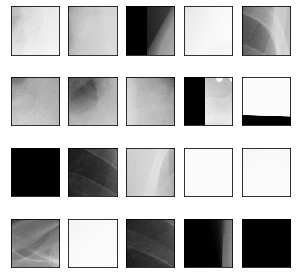

In [12]:
randomFile = random.sample(os.listdir(train_cxr_patch_dir), 20)

n = 1
plt.figure(figsize = (5,5))
for file in randomFile:
    randomImg = cv.imread(os.path.join(train_cxr_patch_dir,file))
    plt.subplot(4, 5, n)
    plt.imshow(randomImg,'gray')
    plt.xticks([]),plt.yticks([])
    n += 1
plt.show()
    

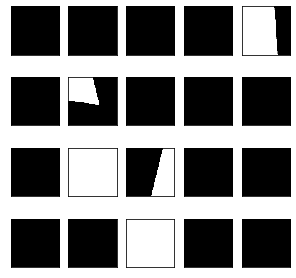

In [13]:
#randomFile = random.sample(os.listdir(train_mask_patch_dir), 20)

n = 1
plt.figure(figsize = (5,5))
for file in randomFile:
    randomImg = cv.imread(os.path.join(train_mask_patch_dir,file))
    plt.subplot(4, 5, n)
    plt.imshow(randomImg,'gray')
    plt.xticks([]),plt.yticks([])
    n += 1
plt.show()